# Figure 1. Overview

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR and $IMAGEN_PROJECT_DIR

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)

from utils import transform, plot
from proc_rest import post_fmriprep
from modeling.check_fit import *

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 12, "font.family": "Asana Math", "figure.dpi": 300})

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
os.makedirs('./figures', exist_ok=True)

## A. BNM example

In [4]:
sub = "sub-608149766930"
SeedMW = 2

Empty surface mesh for the model graph: (Note: The graph itself is manually drawn on top of this)

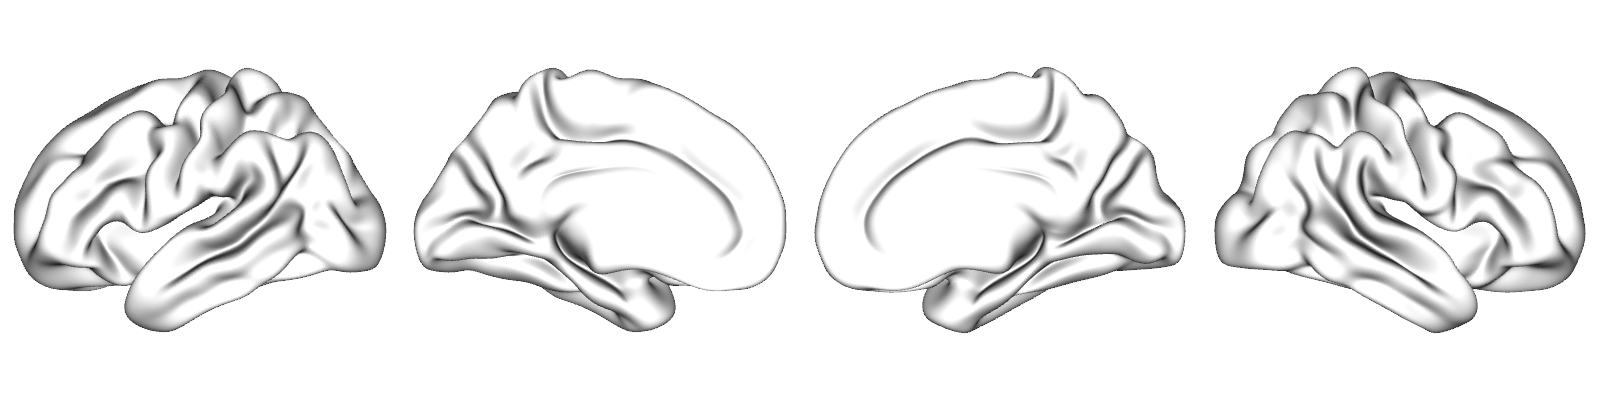

In [5]:
plot.plot_surface(
    np.full(2 * transform.N_VERTICES_HEM_ICO7, np.NaN),
    "fsaverage",
    mesh_kind="semi-inflated",
    nan_color=(1, 1, 1, 1),
    # filename='./figures/1A0.svg'
)

Structural connectome:

(0.0, 100.0, 100.0, 0.0)

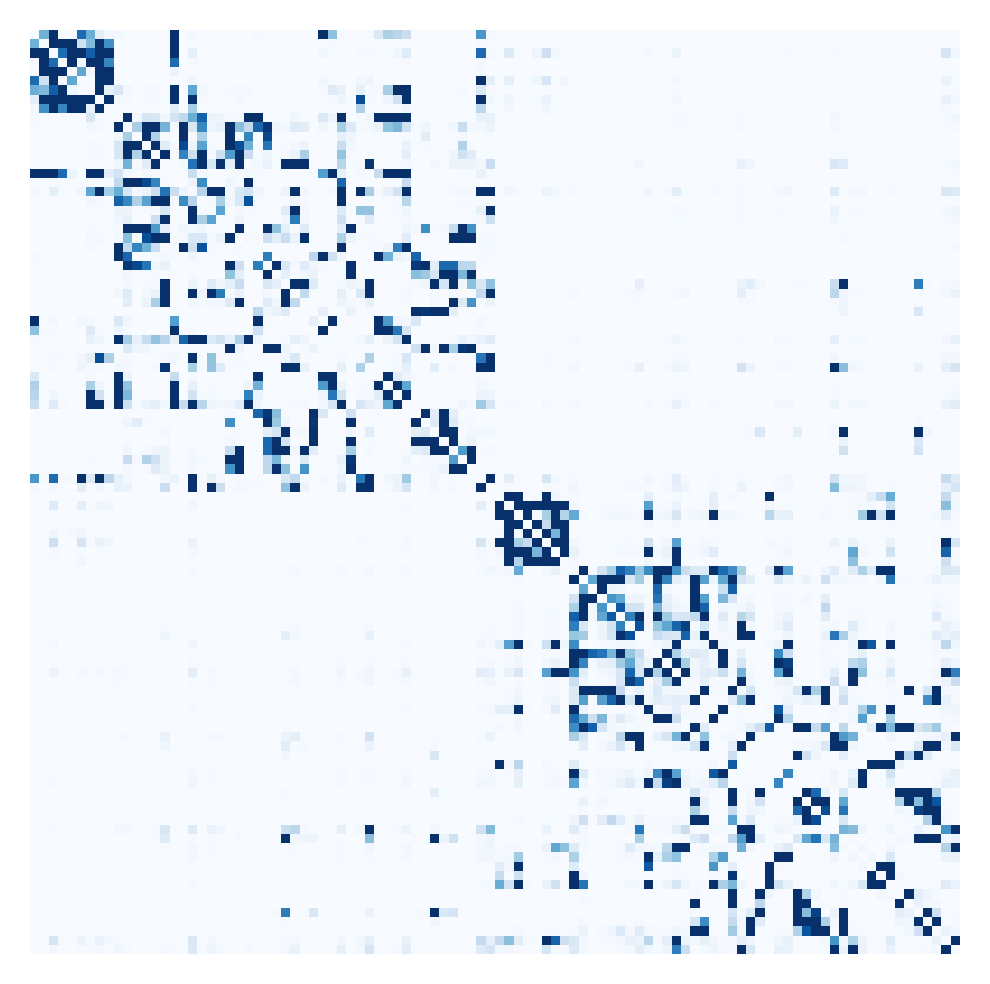

In [6]:
sc = np.loadtxt(
    os.path.join(
        OUTPUT_DIR["pnc"],
        "SC",
        sub,
        "ctx_parc-schaefer-100_mean001_thresh-1_desc-strength.txt",
    )
)
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    sc, cbar=False, ax=ax, vmin=0, vmax=np.quantile(sc.flatten(), 0.95), cmap="Blues"
)
ax.axis("off")
# fig.savefig('./figures/1A1.svg', bbox_inches='tight',pad_inches = 0, dpi = 1200)

Simulated bold:

(0.0, 138.0, -3.5, 3.5)

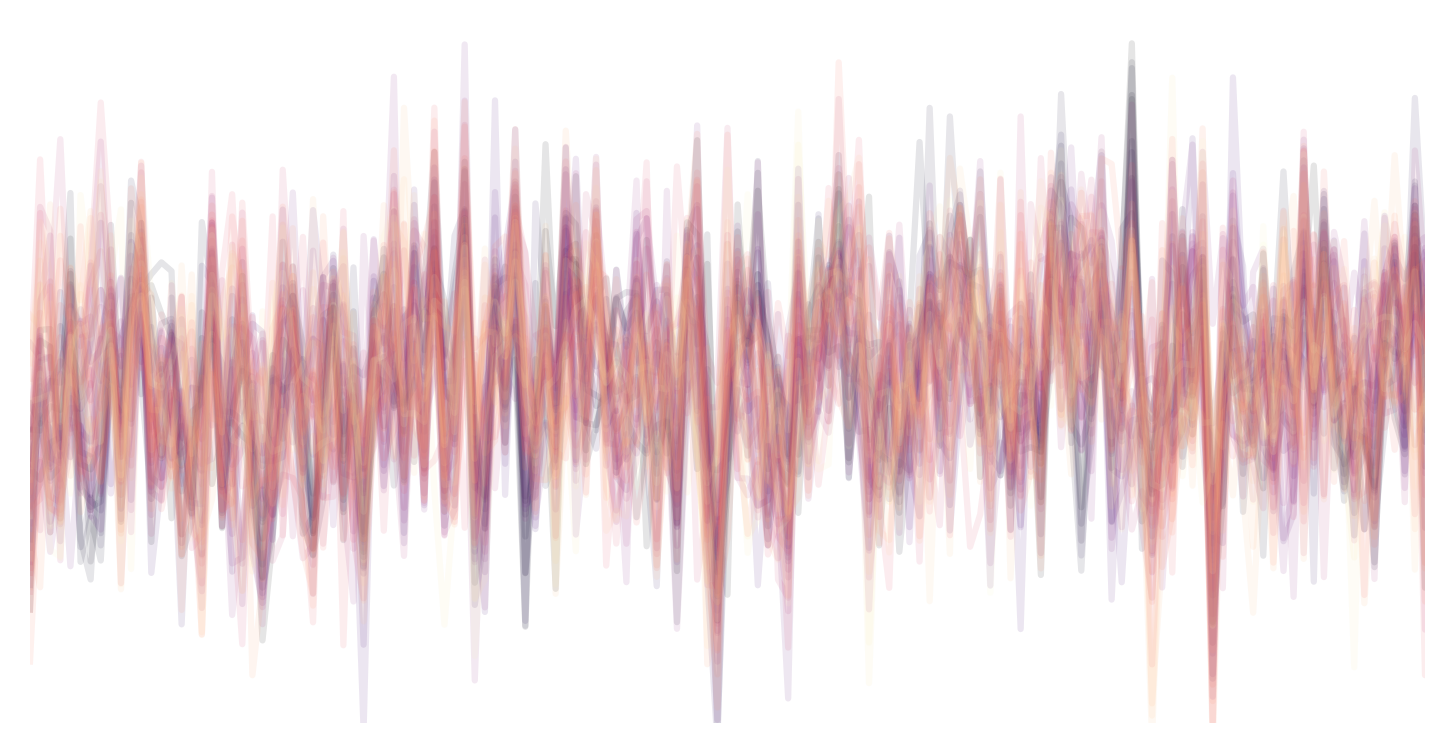

In [7]:
sim_bold = np.loadtxt(
    os.path.join(
        OUTPUT_DIR["pnc"],
        "sim",
        sub,
        "ctx_parc-schaefer-100_mean001_thresh-1",
        "6maps_schaefer-100_zscore",
        "sims_multimaps_gpu",
        f"ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_G_0.5-4_wee_0.05-0.75_wei_0.05-0.75_wie_0_het-wee-wei_SeedMW-{SeedMW}_SeedSim-410_n-81x210_bold.txt",
    )
)
# remove first 10 volumes (30 sec)
sim_bold = sim_bold[10:, :].T

# create long dataframe for plotting
# only include left hemisphere for a less crowded plot
sim_bold_long = (
    pd.DataFrame(scipy.stats.zscore(sim_bold[:50], axis=1)).unstack().reset_index()
)
sim_bold_long.columns = ["time", "region", "bold"]

# plot
fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(
    data=sim_bold_long,
    x="time",
    y="bold",
    hue="region",
    legend=False,
    palette="magma",
    alpha=0.1,
    ax=ax,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim((-3.5, 3.5))
ax.set_xlim((0, 138))
ax.axis("off")
# fig.savefig('./figures/1A2.svg', bbox_inches='tight',pad_inches = 0, dpi = 1200)

Simulated FCD:

(0.0, 66.0, 66.0, 0.0)

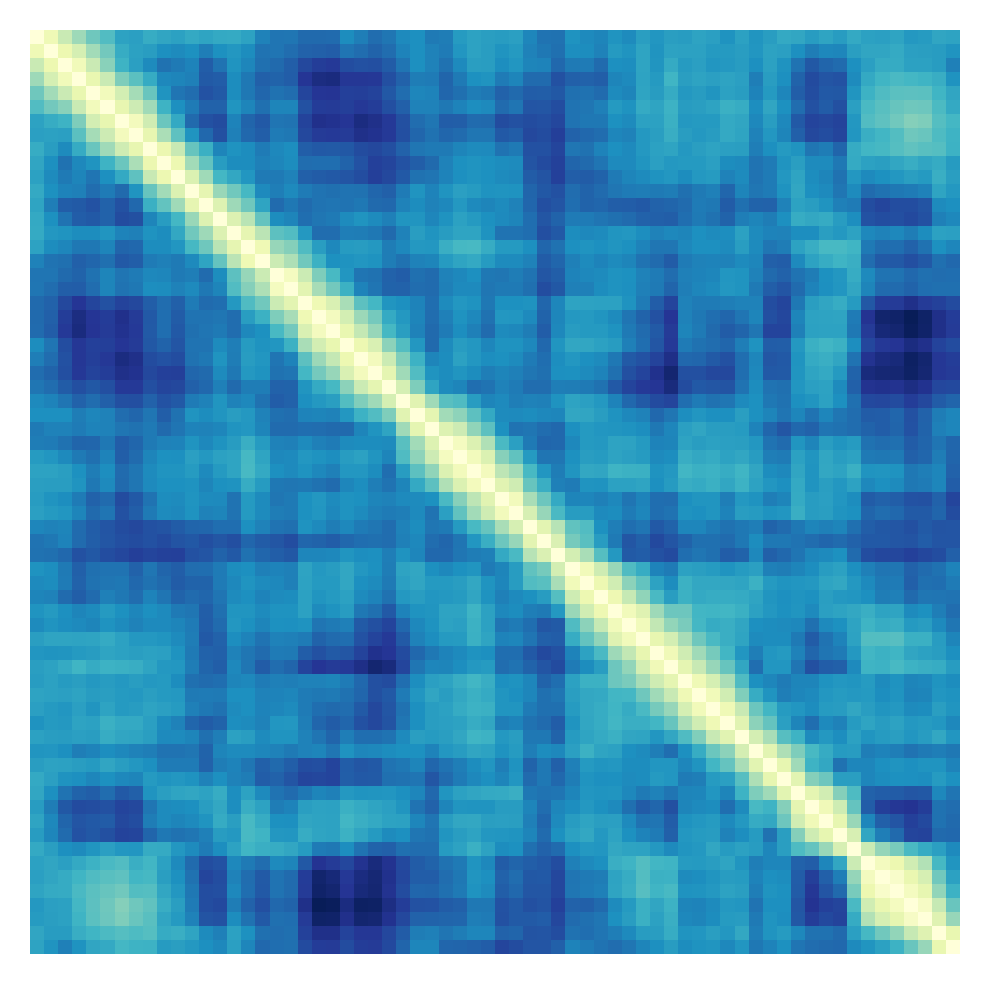

In [8]:
sim_fcd, _ = post_fmriprep.calculate_fcd(
    pd.DataFrame(sim_bold),
    post_fmriprep.WINDOW_SIZE["pnc"],
    post_fmriprep.STEP["pnc"],
    exc_interhemispheric=True,
    hemi_parcs={"L": range(50), "R": range(50, 100)},
)
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    sim_fcd, cbar=False, ax=ax, vmin=sim_fcd.min(), vmax=sim_fcd.max(), cmap="YlGnBu_r"
)
ax.axis("off")
# fig.savefig('./figures/1A3.svg', bbox_inches='tight',pad_inches = 0, dpi = 1200)

Simulated FC:

(0.0, 100.0, 100.0, 0.0)

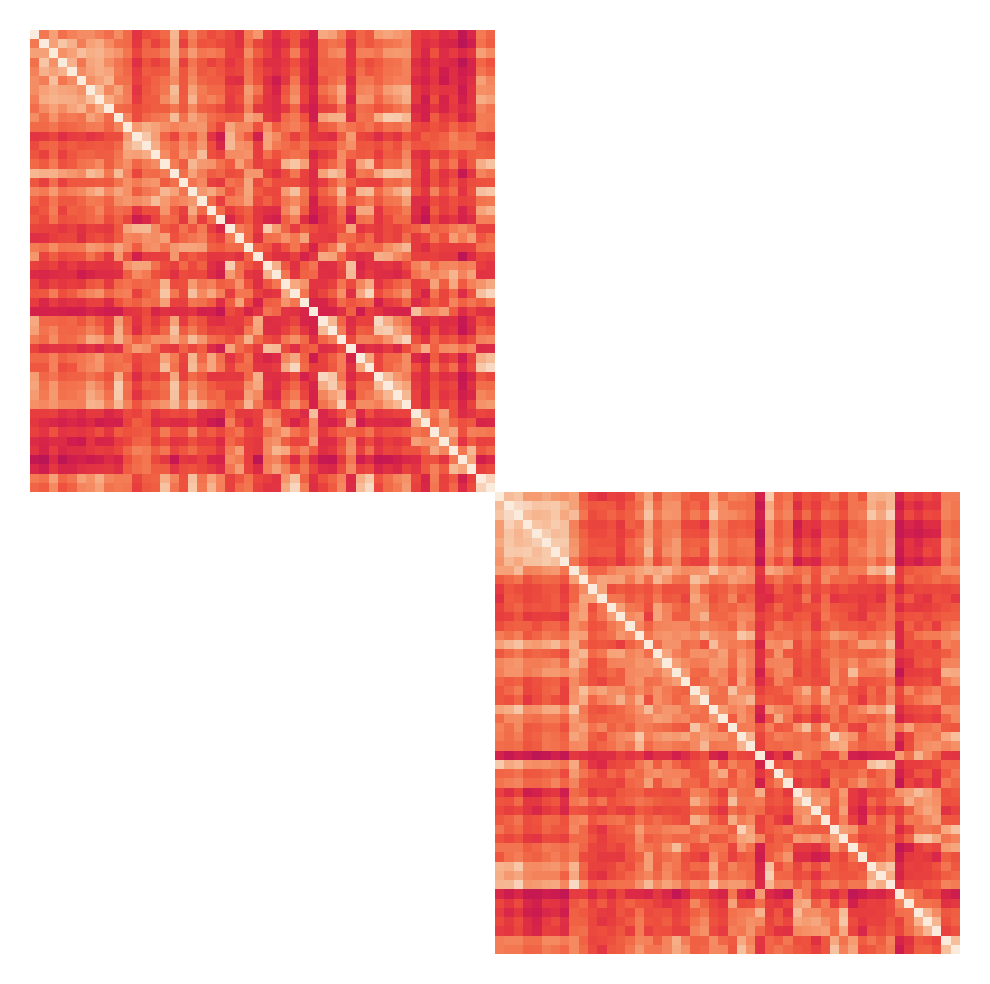

In [9]:
sim_fc = np.full((100, 100), np.NaN)
# calculate FC excluding inter-hemispheric connections
sim_fc[:50, :50] = np.corrcoef(sim_bold[:50])
sim_fc[50:, 50:] = np.corrcoef(sim_bold[50:])
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(sim_fc, cbar=False, ax=ax, vmin=-1, vmax=1)
ax.axis("off")
# fig.savefig('./figures/1A4.svg', bbox_inches='tight',pad_inches = 0, dpi = 1200)

Empirical BOLD:

(0.0, 110.0, -3.5, 3.5)

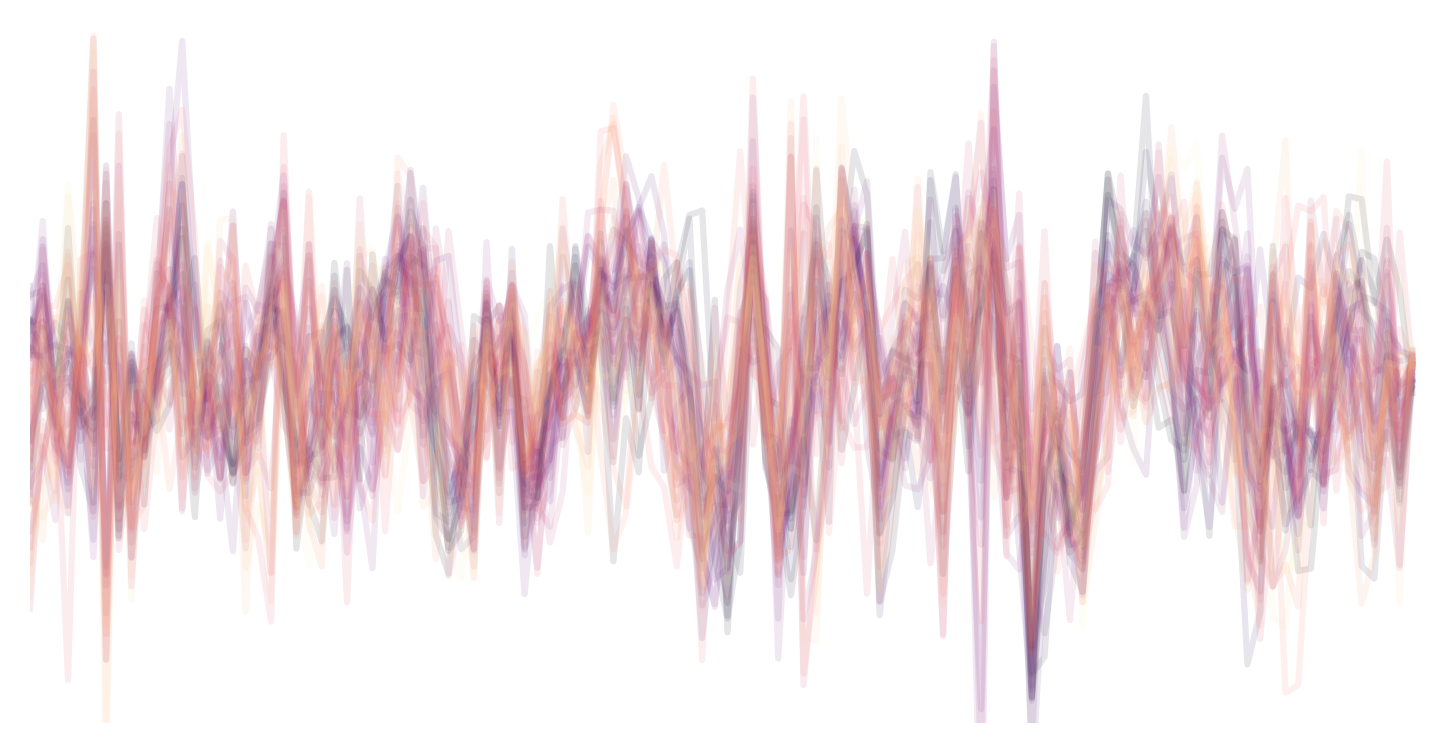

In [10]:
# only using left hemisphere for a less crowded plot
emp_bold = pd.read_csv(
    os.path.join(
        OUTPUT_DIR["pnc"],
        "postfmriprep",
        sub,
        "ctx_parc-schaefer-100_hemi-L_highpass-013_lowpass-none_desc-cleanbold.csv.gz",
    ),
    index_col=0,
)
# remove motion outliers (set to 0)
emp_bold = emp_bold.loc[:, ~(emp_bold == 0).all(axis=0)]
# convert to long
emp_bold_long = emp_bold.unstack().reset_index()
emp_bold_long.columns = ["time", "region", "bold"]

fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(
    data=emp_bold_long,
    x="time",
    y="bold",
    hue="region",
    legend=False,
    palette="magma",
    alpha=0.1,
    ax=ax,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim((-3.5, 3.5))
ax.set_xlim((0, emp_bold.shape[1]))
ax.axis("off")
# fig.savefig('./figures/1A5.svg', bbox_inches='tight', pad_inches=0, dpi=1200)

Empirical FCD:

(0.0, 56.0, 56.0, 0.0)

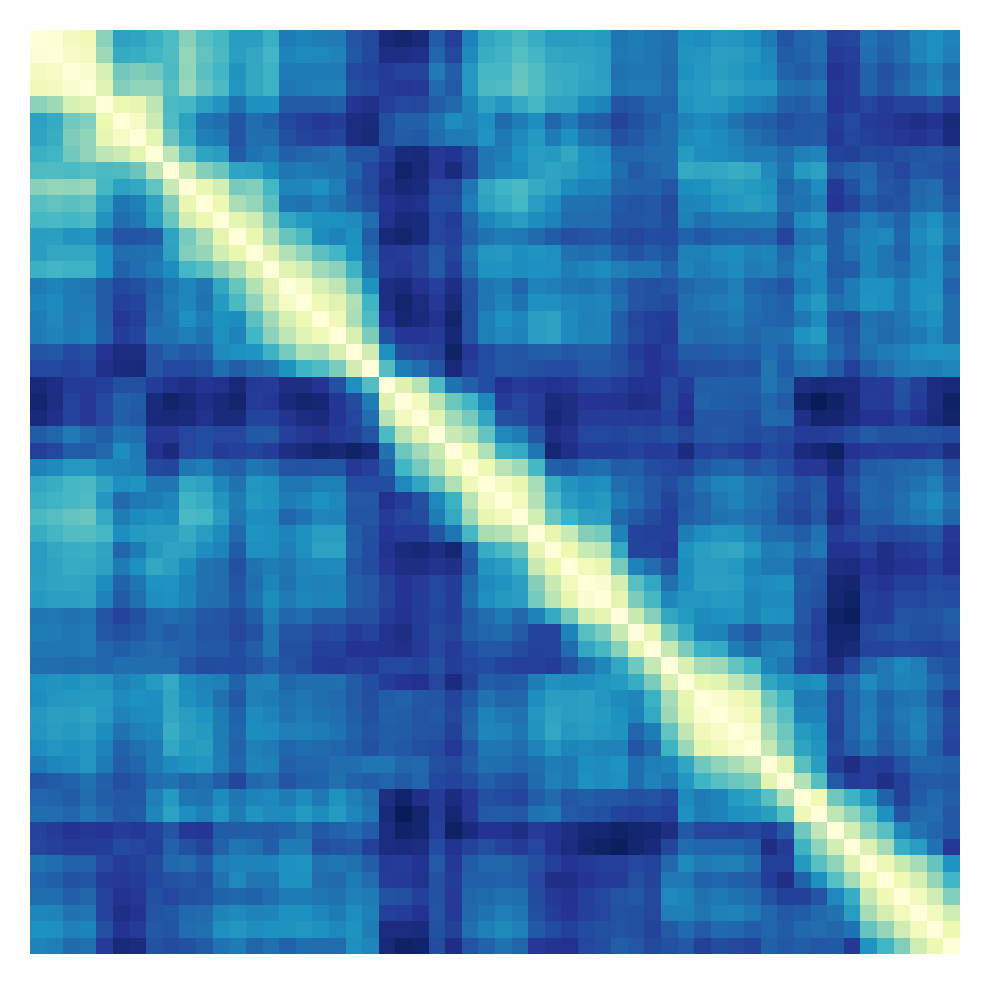

In [11]:
emp_fcd = np.loadtxt(
    os.path.join(
        OUTPUT_DIR["pnc"],
        "FC",
        sub,
        "ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_desc-FCD.txt",
    )
)
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    emp_fcd, cbar=False, ax=ax, vmin=emp_fcd.min(), vmax=emp_fcd.max(), cmap="YlGnBu_r"
)
ax.axis("off")
# fig.savefig('./figures/1A6.svg', bbox_inches='tight', pad_inches=0, dpi=1200)

Empirical FC:

(0.0, 100.0, 100.0, 0.0)

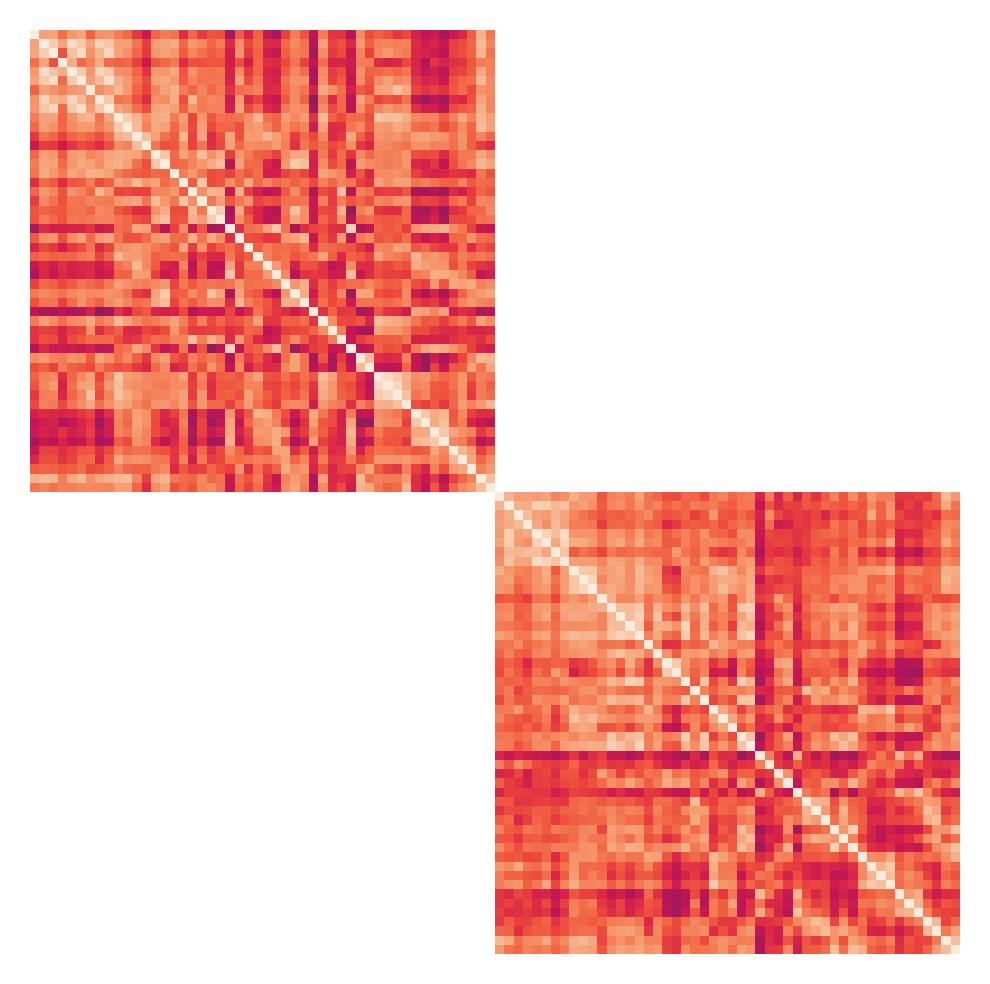

In [12]:
emp_fc = pd.read_csv(
    os.path.join(
        OUTPUT_DIR["pnc"],
        "FC",
        sub,
        "ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_desc-FC.csv.gz",
    ),
    index_col=0,
).values
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(emp_fc, cbar=False, ax=ax, vmin=-1, vmax=1)
ax.axis("off")
# fig.savefig('./figures/1A7.svg', bbox_inches='tight', pad_inches=0, dpi=1200)

FCD distributions:

[]

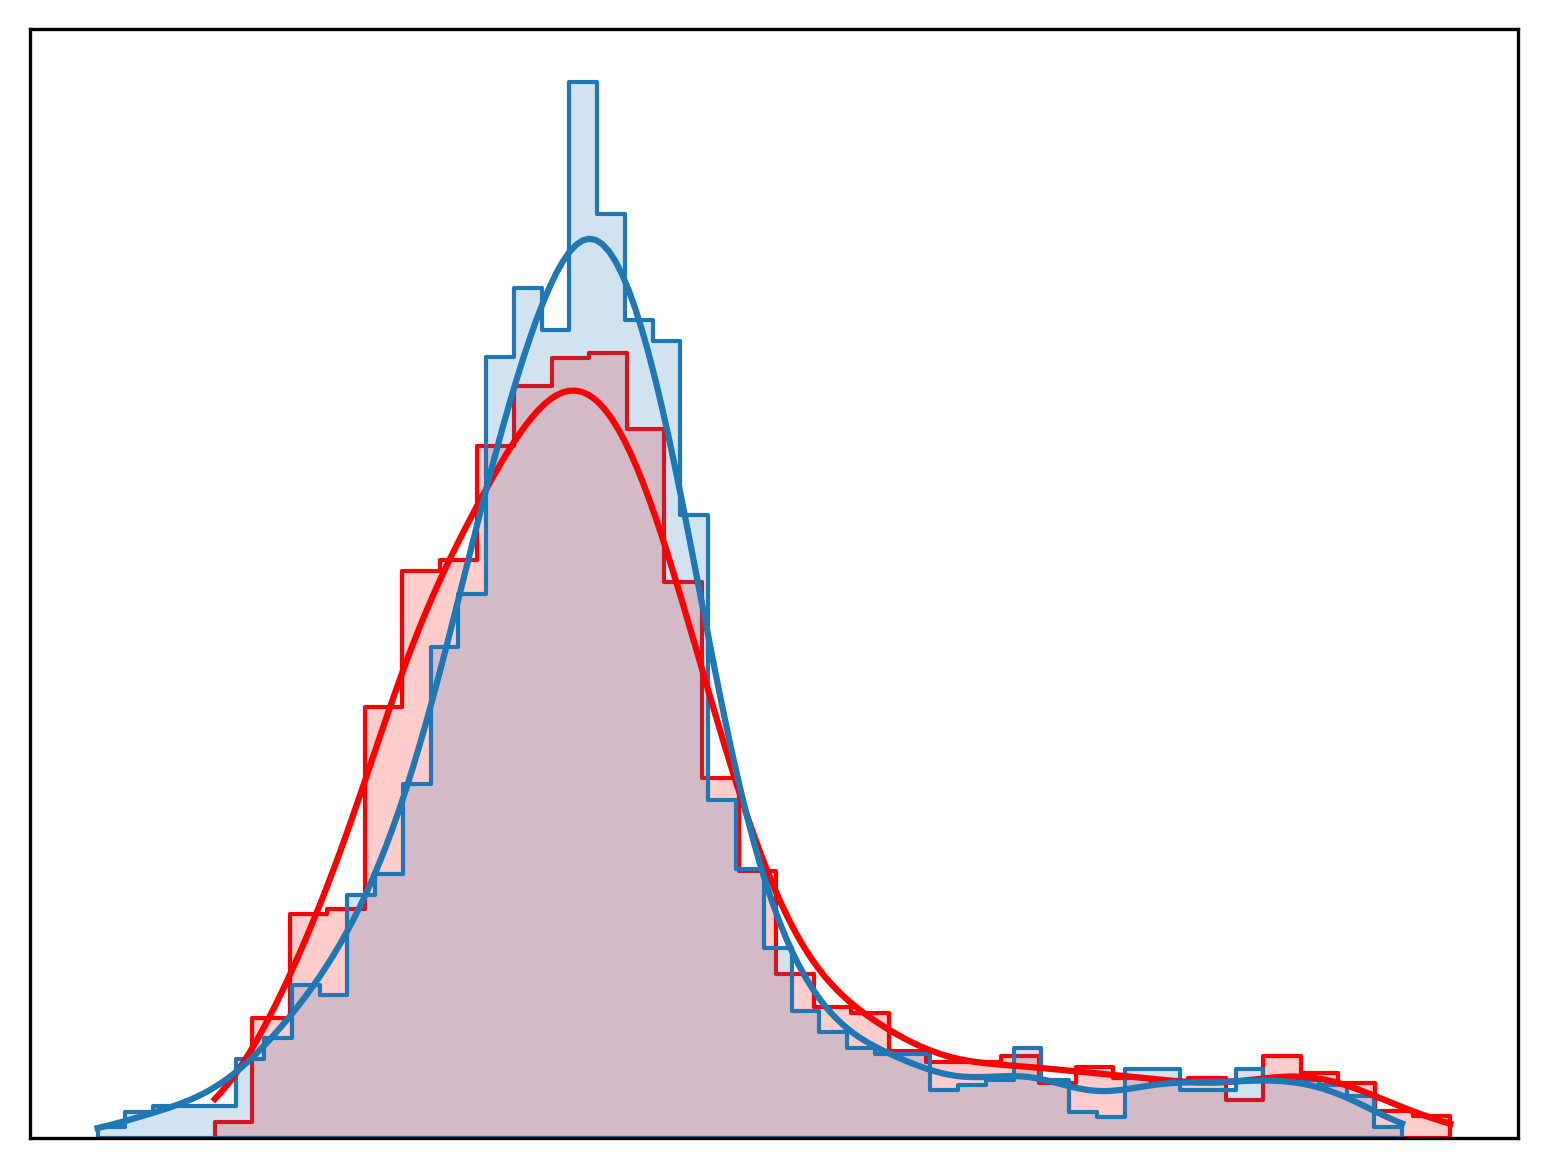

In [13]:
fig, ax = plt.subplots()
sns.histplot(
    emp_fcd[np.tril_indices_from(emp_fcd, -1)],
    kde=True,
    element="step",
    color="red",
    stat="density",
    alpha=0.2,
)
sns.histplot(
    sim_fcd[np.tril_indices_from(sim_fcd, -1)],
    kde=True,
    element="step",
    color="C0",
    stat="density",
    alpha=0.2,
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])
# fig.savefig('./figures/1A8.svg', bbox_inches='tight', pad_inches=0, dpi=1200)

FC correlation:

[]

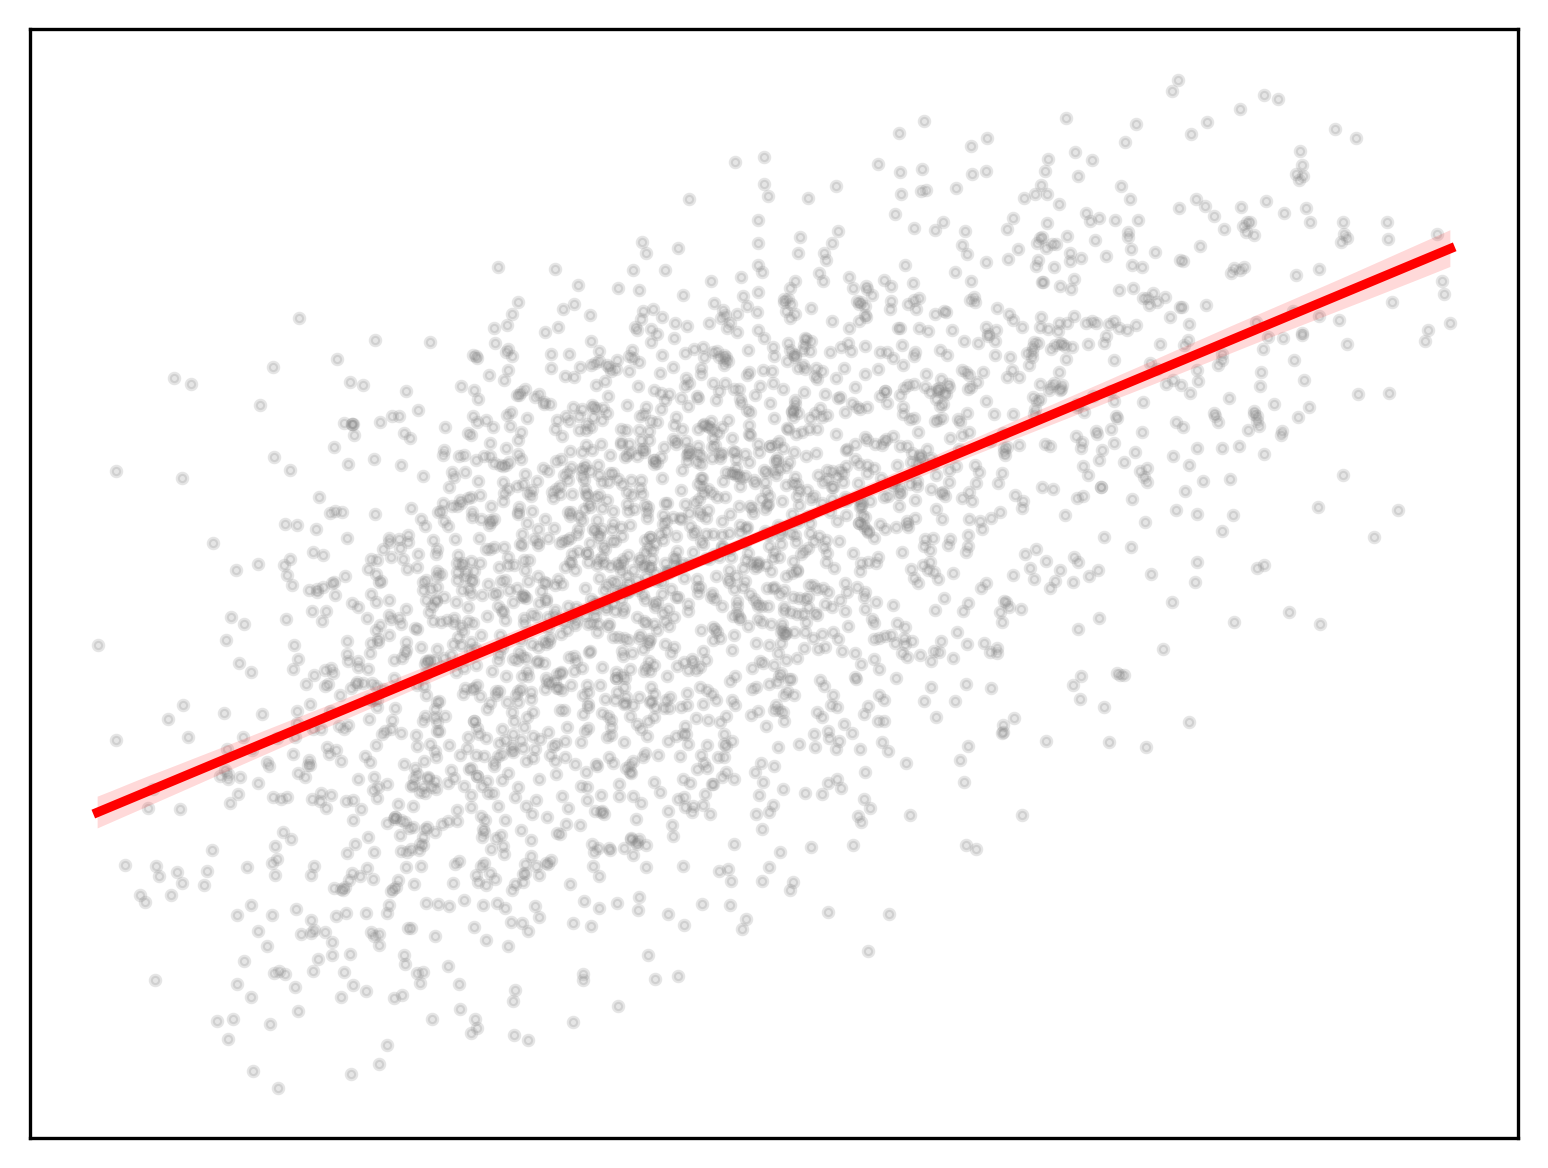

In [14]:
fig, ax = plt.subplots()
sns.regplot(
    x=sim_fc[np.tril_indices(100, -1)],
    y=emp_fc[np.tril_indices(100, -1)],
    scatter_kws=dict(s=5, alpha=0.2, color="grey"),
    line_kws=dict(color="red"),
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])
# fig.savefig('./figures/1A9.svg', bbox_inches='tight', pad_inches=0, dpi=1200)

## C. CMAES history

Load the CMAES history for the example subject and CMAES run:

In [15]:
itMax = 81
lmbda = 210
params = {
    "G": "0.5-4",
    "wee": "0.05-0.75",
    "wei": "0.05-0.75",
    "wie": "0",
}
het_params = "wee-wei"
cmaes_folder = os.path.join(
    OUTPUT_DIR["pnc"],
    "sim",
    sub,
    "ctx_parc-schaefer-100_mean001_thresh-1",
    "6maps_schaefer-100_zscore",
    "cmaes_multimaps_gpu",
)

hist, optima_hist, optima_hist_cumulative = load_cmaes_hist(
    cmaes_folder, params, het_params, SeedMW=SeedMW
)
hist["gof"] += 1  # an extra -1 was added to gof during CMAES in these runs; remove it

Plot:

Text(0.5, 0, 'Generation')

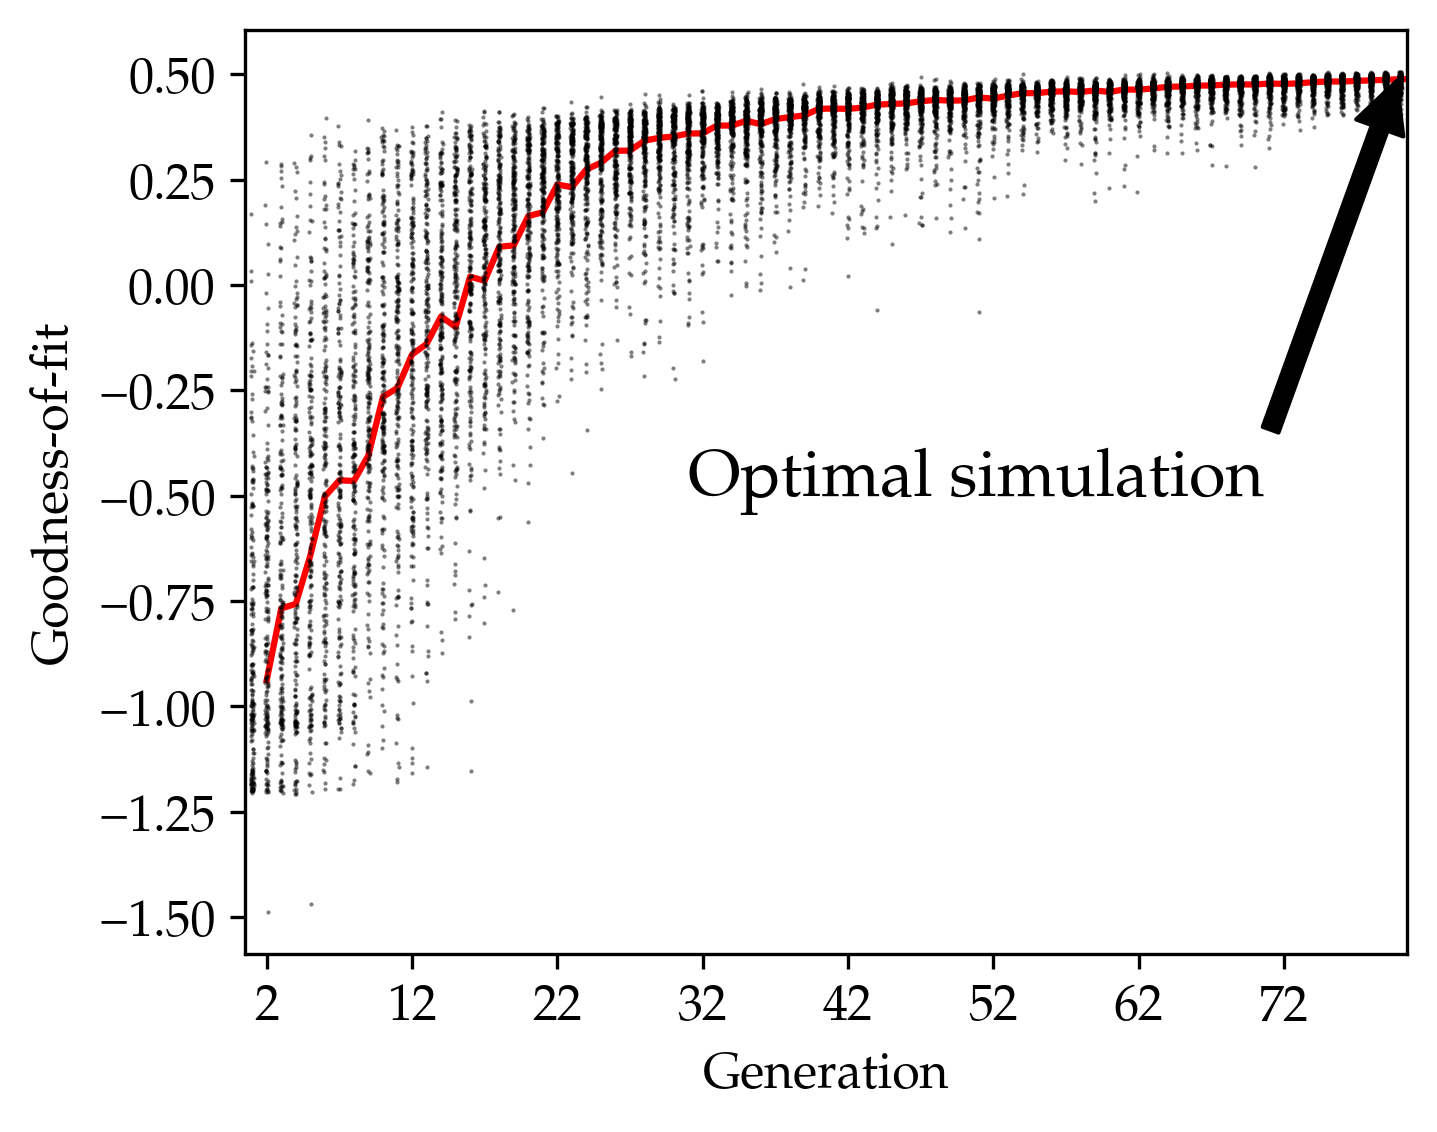

In [16]:
fig, ax = plt.subplots(figsize=(5, 4))
hist["iteration"] = hist["iteration"].astype("int")
hist_median = hist.groupby("iteration")["gof"].median()
ax.plot(hist_median, color="red")
sns.stripplot(data=hist, x="iteration", y="gof", s=1, alpha=0.5, color="black", ax=ax)
ax.annotate(
    "Optimal simulation",
    xy=(
        hist.loc[hist["gof"].idxmax(), "iteration"],
        hist.loc[hist["gof"].idxmax(), "gof"],
    ),
    xytext=(30, -0.5),
    fontsize=16,
    arrowprops=dict(facecolor="black", shrink=0.025),
)
ax.set_xticks(np.arange(1, 81, 10))
ax.set_ylabel("Goodness-of-fit")
ax.set_xlabel("Generation")
# fig.savefig('./figures/1C.svg', bbox_inches='tight', pad_inches=0, dpi=1200)

## D. $I_i^E$ time series and average map

To get the timeseries, the optimal simulation of this subject needs to be re-run using cuBNM while timeseries of model states are saved.

Run simulation:

In [17]:
# !python run_sim.py $sub $SeedMW

Load simulation data:

In [18]:
sim_data = np.load(
    os.path.join(
        os.environ["PNC_PROJECT_DIR"], "output",
        "sim", sub,
        "ctx_parc-schaefer-100_mean001_thresh-1",
        "6maps_schaefer-100_zscore", "cmaes_multimaps_gpu",
        f"ctx_parc-schaefer-100_hemi-LR_highpass-013_lowpass-none_exc-inter_G_0.5-4_wee_0.05-0.75_wei_0.05-0.75_wie_0_het-wee-wei_SeedMW-{SeedMW}_SeedSim-410_n-81x210_cubnm",
        "ts", "it1.npz",
    ),
    allow_pickle=True,
)

Plot $I_i^E$ time series for 10 nodes:

(-4.95, 103.95, 0.12439689441665441, 10.470266814551588)

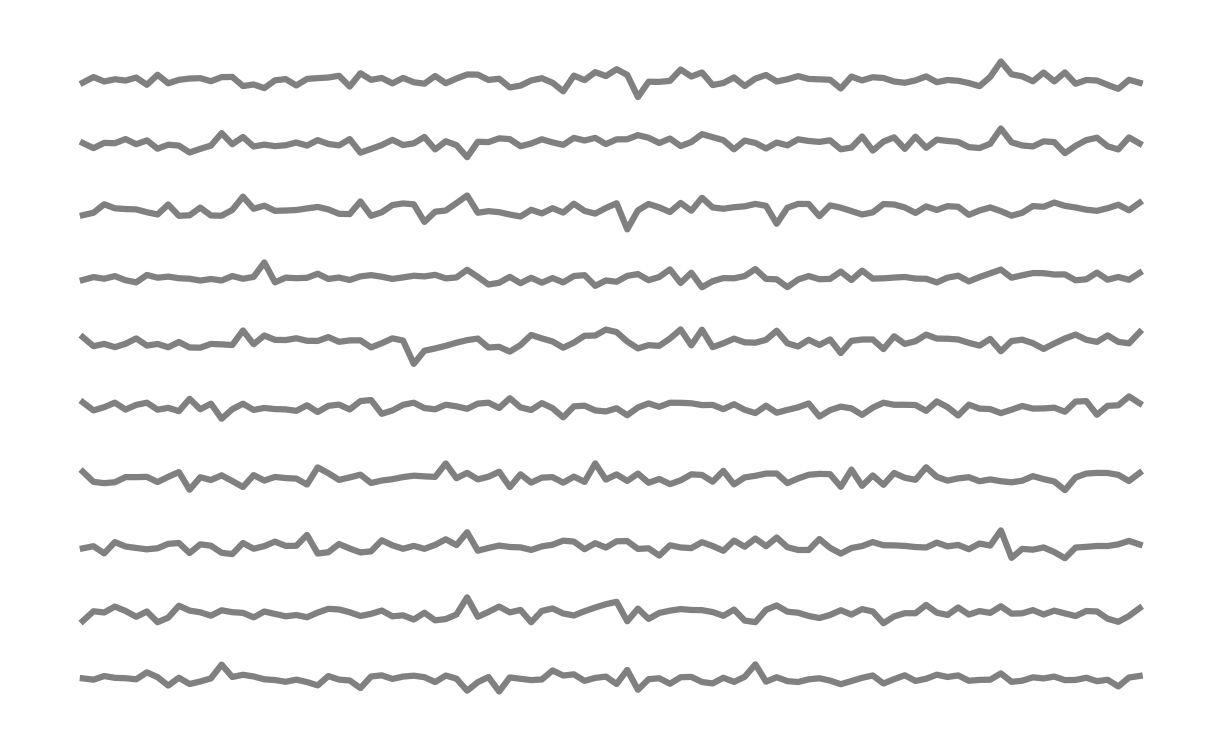

In [19]:
# load the timeseries and remove the initial 30s
sim_I_E = sim_data["sim_states"].reshape(1)[0]["I_E"][0, 10:]
sim_I_E = pd.DataFrame(sim_I_E)

# plot 10 regions
fig, ax = plt.subplots(figsize=(5, 3))
for i in range(0, 100, 10):
    ax.plot(
        sim_I_E.columns,
        0.10 * i + (sim_I_E.iloc[i, :] / sim_I_E.iloc[i, :].max()),
        color="grey",
    )
ax.axis("off")
# fig.savefig('./figures/1D0.svg', bbox_inches='tight', pad_inches=0, dpi=1200)

Plot E-I ratio ($\langle I_i^E \rangle$) map:

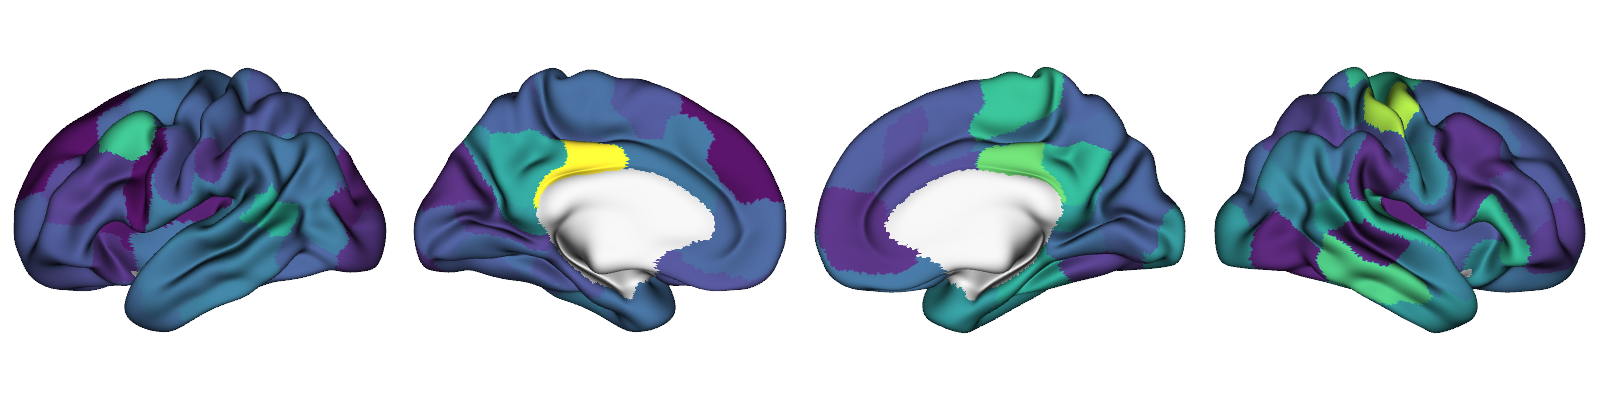

In [20]:
mean_sim_I_E = sim_I_E.mean(axis=0)
mean_sim_I_E.index = transform.load_ordered_parcel_labels("schaefer-100")
plot.plot_surface(
    transform.deparcellate_surf(
        mean_sim_I_E, "schaefer-100", concat=True, space="fsaverage"
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    cmap="viridis",
    cbar=False,
    # filename='./figures/1D1.svg'
)